# Quantum Kernel-Based Machine Learning Tutorial


## Introduction to Machine Learning and Kernels
Machine Learning (ML) is a field of artificial intelligence that focuses on building systems capable of learning from data to make predictions or decisions. A common ML task is classification, where we try to assign labels to data points. ML models learn patterns from the data and generalize these patterns to make predictions on unseen data.

### What are Kernels?
A **kernel** is a function that computes a similarity measure between two data points. In ML, kernels are often used to implicitly map data into a higher-dimensional space without computing the transformation explicitly. This enables algorithms like Support Vector Machines (SVM) to solve problems that are not linearly separable in the original feature space.

In this tutorial, we will use the **Quantum Evolution Kernel**, a custom kernel that computes the similarity between graph-structured data using quantum-inspired techniques. This kernel is particularly suited for problems involving structured or relational data.

## Tutorial Objectives
This tutorial will guide you through:
1. Loading and preprocessing a dataset for kernel-based machine learning.
2. Training and evaluating a Support Vector Machine (SVM) using the Quantum Evolution Kernel.
3. Integrating the kernel and SVM into a scikit-learn pipeline for streamlined workflows.
4. Performing hyperparameter optimization using GridSearchCV to improve model performance.


## Loading the Data

We begin by loading a dataset that contains graph-structured data. Each data point is represented as a processed object with features and a target value. We will split the data into training and testing sets for model evaluation.
    

In [11]:
import qek.data.datatools as qek_datatools
from sklearn.model_selection import train_test_split

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [12]:
# Load the presaved dataset
processed_dataset = qek_datatools.load_dataset(file_path='ptcfm_processed_dataset.json')
print(f'Size of the quantum compatible dataset = {len(processed_dataset)}')

Size of the quantum compatible dataset = 279


In [13]:
# Prepare features (X) and targets (y)
X = [data for data in processed_dataset]  
y = [data.target for data in processed_dataset] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [14]:
print(f'Size of the training quantum compatible dataset = {len(X_train)}')
print(f'Size of the testing quantum compatible dataset = {len(X_test)}')

Size of the training quantum compatible dataset = 223
Size of the testing quantum compatible dataset = 56


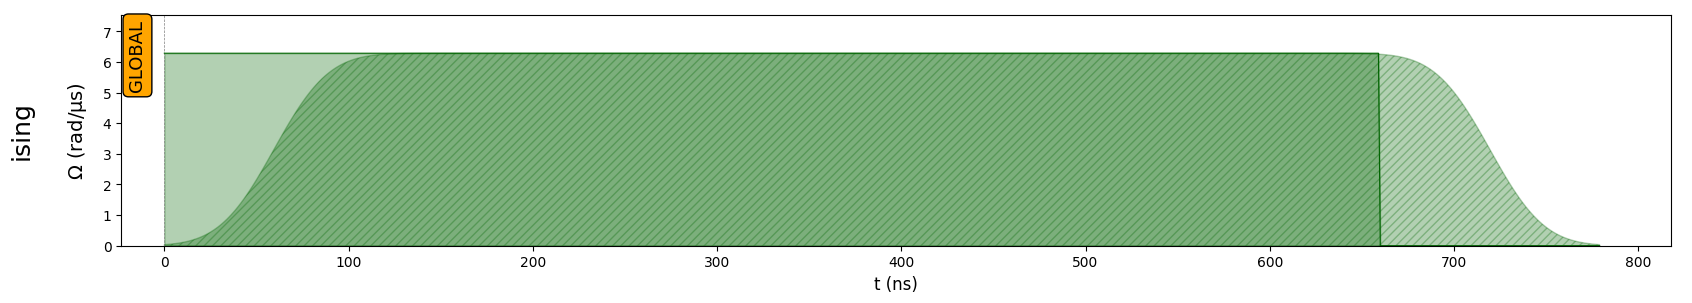

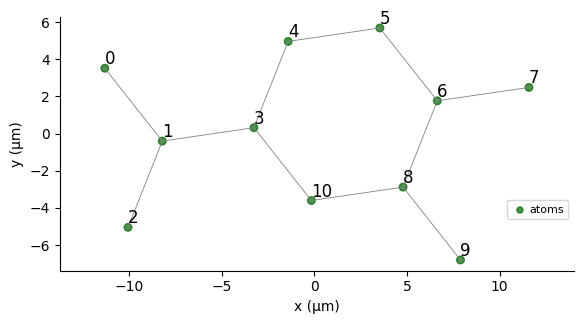

In [15]:
dataset_example = X[64]
dataset_example.draw_sequence()
dataset_example.draw_register()

## Using the Quantum Evolution Kernel

The Quantum Evolution Kernel computes a similarity score between two graphs based on quantum-inspired measures. It is designed to work with graph-structured data and leverages quantum mechanics principles to capture relationships between data points.
    

In [16]:
from qek.kernel import QuantumEvolutionKernel

# Initialize the Quantum Evolution Kernel with a parameter mu
kernel = QuantumEvolutionKernel(mu=0.5)

In [17]:
# Fit
kernel.fit(X_train)

# Transform
K_train = kernel.transform(X_train)
K_test = kernel.transform(X_test)

AttributeError: 'QuantumEvolutionKernel' object has no attribute 'fit'

The kernel matrix for the testing dataset looks like:

In [18]:
print(f"Training Kernel Matrix Shape: {K_train.shape}")
print(f"Testing Kernel Matrix Shape: {K_test.shape}")

NameError: name 'K_train' is not defined

In [19]:
K_train

NameError: name 'K_train' is not defined

## Training a simple model 

We can train a simple sklearn SVM model using the QuantumEvolutionKernel

In [20]:
from sklearn.svm import SVC
from qek.kernel import QuantumEvolutionKernel
from sklearn.metrics import accuracy_score

In [21]:
qek_kernel = QuantumEvolutionKernel(mu=0.5)
model = SVC(kernel=qek_kernel, random_state=42)
model

SVC(kernel=<qek.kernel.kernel.QuantumEvolutionKernel object at 0x16c76c730>,
    random_state=42)

In [22]:
# This does not work yet. 
# The reason is that SVM model needs the kernel __call__ to accept list of inputs 
# and QEK only accepts single inputs
# model.fit(X_train, y_train)

In [23]:
# Making predictions using the trained model
# y_pred = model.predict(X_test)


# accuracy = accuracy_score(y_test, y_pred)
# print(f"Pipeline Accuracy: {accuracy:.2f}")
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

## Creating a Pipeline with SVM

Pipelines in scikit-learn allow us to streamline the workflow by chaining preprocessing steps and models. In this step, we integrate the Quantum Evolution Kernel with an SVM classifier in a pipeline for end-to-end model training and prediction.

In [24]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [25]:
 # Define the pipeline
pipeline = Pipeline([
    ('quantum_kernel', QuantumEvolutionKernel(mu=0.5)),
    ('svm', SVC(kernel='precomputed', random_state=42))
])

In [26]:
# Train the pipeline
pipeline.fit(X_train, y_train)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '<qek.kernel.kernel.QuantumEvolutionKernel object at 0x16c76e7d0>' (type <class 'qek.kernel.kernel.QuantumEvolutionKernel'>) doesn't

In [ ]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

In [17]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Pipeline Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Pipeline Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.82      0.70        33
           1       0.50      0.26      0.34        23

    accuracy                           0.59        56
   macro avg       0.56      0.54      0.52        56
weighted avg       0.57      0.59      0.55        56



## GridSearchCV for Hyperparameter Optimization


Hyperparameter tuning is a critical step in improving model performance. GridSearchCV systematically searches through a predefined set of hyperparameters to find the combination that yields the best results. Here, we optimize:

- `mu`: A parameter of the Quantum Evolution Kernel.
- `C`: The regularization parameter of the SVM.

Additionally, we employ multiple scoring metrics such as F1 Score and Balanced Accuracy to evaluate the performance of the models comprehensively.
    

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define scoring metrics
scoring = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "f1_score": make_scorer(f1_score, average="weighted")
}

# Define cross-validation strategy
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Define parameter grid
param_grid = {
    'quantum_kernel__mu': np.linspace(0.1, 2.0, 10),
    'svm__C': np.logspace(-3, 2, 10)
}

We will use the pipeline defined in the previous section inside the grid search

In [ ]:
grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring, cv=skf, refit="f1_score", n_jobs=-1, return_train_score=True
)

In [ ]:
# Perform grid search
grid_search.fit(X_train, y_train)

In [ ]:
# Extract results
cv_results = grid_search.cv_results_

In [ ]:
# Plot CV results for F1 score
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_quantum_kernel__mu'], cv_results['mean_test_f1_score'], label='Mean F1 Score')
plt.fill_between(cv_results['param_quantum_kernel__mu'],
                    np.array(cv_results['mean_test_f1_score']) - np.array(cv_results['std_test_f1_score']),
                    np.array(cv_results['mean_test_f1_score']) + np.array(cv_results['std_test_f1_score']), alpha=0.2)
plt.title("Grid Search Cross-Validation Results")
plt.xlabel("Quantum Kernel Parameter (mu)")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

We can get the best model from the grid_search using the best_estimator_, and use it to make predictions

In [ ]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy:.2f}")